In [1]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import splitfolders
from tensorflow.keras.preprocessing import image

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 66% 31.0M/47.0M [00:00<00:00, 169MB/s] 
100% 47.0M/47.0M [00:00<00:00, 170MB/s]


In [10]:
# ekstrak file zip
local_zip = '/content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [30]:
# Buat directori baru untuk menyimpan data train dan val
train = r'/content/data/train'
val = r'/content/data/val'
if not os.path.exists(train):
    os.makedirs(train)
if not os.path.exists(val):
    os.makedirs(val)

In [12]:
# copy file ke folder train dan val dengan rasio 6:4 atau 60% dan 40%
splitfolders.ratio("/content/Shoe vs Sandal vs Boot Dataset", output="/content/data",seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 15000 files [00:02, 5028.25 files/s]


In [31]:
# Buat path yang mengarah ke directori train dan val
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [32]:
# menampilkan isi directori train
os.listdir(train_dir)

['Sandal', 'Boot', 'Shoe']

In [33]:
# menampilkan isi directori val
os.listdir(val_dir)

['Sandal', 'Boot', 'Shoe']

In [34]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range = 0.2,
                fill_mode = 'nearest')
validation_datagen = ImageDataGenerator(rescale = 1.0/255)

In [35]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir, 
        target_size=(150,150), 
        batch_size=32,
        class_mode='categorical')

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [36]:
train_generator.class_indices

{'Boot': 0, 'Sandal': 1, 'Shoe': 2}

In [37]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [38]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nAkurasi model telah mencapai 92%")
      self.model.stop_training = True
callbacks = myCallback()

In [39]:
# compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs= 20,
      batch_size=128,
      verbose=2,
      callbacks=[callbacks]
)

Epoch 1/20
375/375 - 282s - loss: 0.6860 - accuracy: 0.6933 - val_loss: 0.3813 - val_accuracy: 0.8753 - 282s/epoch - 753ms/step
Epoch 2/20
375/375 - 290s - loss: 0.3682 - accuracy: 0.8588 - val_loss: 0.3487 - val_accuracy: 0.8803 - 290s/epoch - 773ms/step
Epoch 3/20
375/375 - 293s - loss: 0.3020 - accuracy: 0.8860 - val_loss: 0.2983 - val_accuracy: 0.9007 - 293s/epoch - 780ms/step
Epoch 4/20
375/375 - 292s - loss: 0.2480 - accuracy: 0.9081 - val_loss: 0.2087 - val_accuracy: 0.9347 - 292s/epoch - 780ms/step
Epoch 5/20
375/375 - 291s - loss: 0.2155 - accuracy: 0.9226 - val_loss: 0.2123 - val_accuracy: 0.9367 - 291s/epoch - 777ms/step
Epoch 6/20
375/375 - 294s - loss: 0.1909 - accuracy: 0.9326 - val_loss: 0.1955 - val_accuracy: 0.9327 - 294s/epoch - 784ms/step
Epoch 7/20
375/375 - 294s - loss: 0.1657 - accuracy: 0.9397 - val_loss: 0.1522 - val_accuracy: 0.9493 - 294s/epoch - 784ms/step
Epoch 8/20
375/375 - 286s - loss: 0.1494 - accuracy: 0.9471 - val_loss: 0.1776 - val_accuracy: 0.9390 - 

In [41]:
# evaluasi performa model yang telah dibuat
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

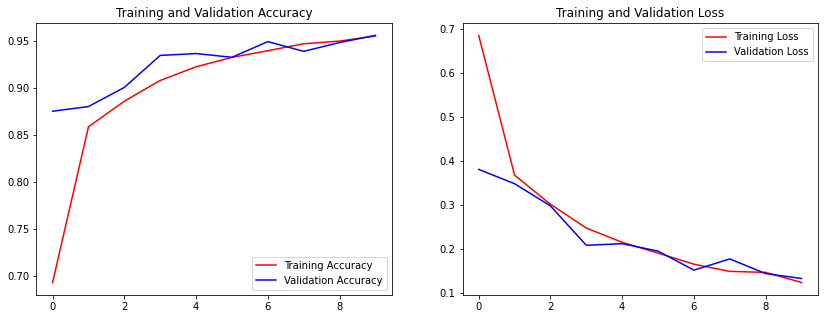

In [42]:
eval_plot(history)

In [44]:
# fungsi untuk prediksi gambar
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  probabilitas = sorted(model.predict(im_input)[0])[2]
  classes = np.argmax(model.predict(im_input))

  if classes == 0:
      label = 'Boot'
  elif classes == 1:
      label = 'Sandal'
  elif classes == 2:
      label = 'Shoe'
  else:
      label = 'Unknown'

  print('\n')
  plt.show()
  print("\nHasil Klasifikasi Gambar: ", label)
  print("Probability: ", round(probabilitas*100,2), "%")
  print('\n')

Saving 71D9ImsvEtL._UY500_.jpg to 71D9ImsvEtL._UY500_.jpg
1/1 [==============================] - 0s 26ms/step




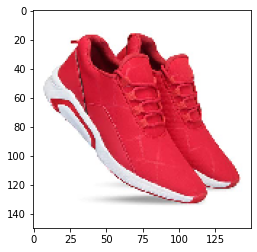


Hasil Klasifikasi Gambar:  Shoe
Probability:  81.53 %




In [52]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

predict_image(img)

In [54]:
# Convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)